# ChestXray

- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and its comments, as it contains variables and information that you may need to use to complete the notebook.
- To create a text cell, create it with the "+" button and change its type from "Code" to "Markdown" using the top menu. To modify a text cell, double click on it.
- If you are interested, you can check detail on formatting markdown text here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- The accuracies provided as required for each question are there to make sure you work enough on each model to get a good result. Part of the grade is based on this.

Tips for training deep learning models:
- Since the datasets being used here are small, you are probably going to have to use early stopping as a way of preventing overfitting. This means you will have to save models in the middle of training. One of the ways to save models on memory is to do a deep copy of it (using ```copy.deepcopy``` ). 
- It is also recommended to frequently (at least once every epoch) print the loss of the model and the score it is getting at its intended task, to follow if the model is learning something and if it is still improving. Usually you will need somewhere between 1 and 15 epochs for your model to get the required accuracy in this assignment.
- To search for the best hyperparameters for your model, it is usually better to start searching in a logarithmic scale. Usually powers of 2 or 10 are used. 
- In https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2, different optimal learning rates for different optimizers were found for a different task. This could help in your search of optimal learning rate. For this assignment, you will probably get the best results by using Adam and searching for the best learning rate in the range of good learning rates provided in the cited page, which for Adam is from 0.00005 to 0.01.
- Batch size seems to have a smaller impact than learning rate in the results. It should be enough if you test batch sizes between 8 and 32.
- We assume a GPU of at least 4GB of memory is available. If you want to try running the assignment with a GPU that has less than that, you can try changing the argument passed when calling the ```define_gpu_to_use``` function.  If you are getting out-of-memory errors for the GPU, you may want to check what is occupying the GPU memory by using the command ```!nvidia-smi```, which gives a report of the use of the GPU. 
- For some of the questions, it might be useful for you to understand what the resnet18 PyTorch model is doing. You can have access to its source code here: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py . The most important part to understand should be the ```forward``` function from the ```ResNet``` class. It might also be useful to print PyTorch models using ```print(model)```. This should give you a list of all the layers present in the model.
- Between CADE and COLAB (i.e. Google Colaboratory), CADE is probably the best option for running this assignment, since it seems to be about 50% faster than COLAB and files are not erased when resetting sessions. CADE has a small disk quota for the home directory, so it might be necessary, depending on how much your home directory is already occupied, to store the virtual environment inside a folder in ```/scratch/tmp/```. For CADE, datasets are already downloaded and stored in a scratch folder accessible to everyone.
- If you are using Google Colaboratory, it might be interesting to store the datasets on your Google Drive to prevent having to download it every time you restart your sessions. For that, you will probably need to add the line ```drive.mount('/content/gdrive')``` and change the ```pre_folder``` variable to ```'gdrive/My Drive'```. This was not tested, so some adjustments may be needed.
- There are a few PyTorch details not to forget:
    - Remember to toggle train/eval mode for your model
    - Remember to reset the gradients with ```zero_grad()``` before each call to ```backward()```
    - Remember to check if the loss you are using receives logits or probabilities, and adapt your model output accordingly.
    - Remember to reinstantiate your model every time you are starting a new training, so that weights are reset.
    - Remember to pass to the optimizer the set of parameters for the model you want to train.
- Starting training from a pretrained model instead of starting it from scratch usually helps to get a better final result. For the exercises that use the resnet18 model from PyTorch, you can start training with the model pretrained on ImageNet that is provided by PyTorch.

#### Installing and loading libraries

In [1]:
!pip install -q kaggle
!pip install pydicom
!pip install scikit-learn

In [2]:
import getpass
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
from sklearn.metrics import roc_curve, auc
import copy
import torchvision.models as models
import tarfile
%matplotlib inline

#### Defining folders where data should be saved/loaded

In [3]:
#checking what kind of system you are using
try:
    import google.colab
    from google.colab import drive
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

#defining the folders where datasets will be, depending on the system
machine_being_used = 'cade' if IN_CADE else ('colab' if IN_COLAB else 'other')
pre_folder = '/scratch/tmp/' if machine_being_used == 'cade' else './'
pneumonia_dataset_folder = pre_folder + 'deep_learning_datasets_ECE_6960_013/kaggle_pneumonia'
xray14_dataset_folder = pre_folder + 'deep_learning_datasets_ECE_6960_013/chestxray14'

#### Defining the GPU to use and reserving its memory for this notebook

In [4]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
#setting the gpu that will be used, testing if it has enough available memory, and reserving the needed memory
define_gpu_to_use()

Chosen GPU: 0


#### Defining functions that are used internally in both exercises

In [6]:
# defining a pre-transformation class that is used to preprocess the images
# this class receives a Pillow Image, and crops it so that it has a 1:1 aspect
# ratio (i.e. a square). It chooses the biggest square possible that fits in the image
# and centers it.
# this is important for medical datasets, since a lot of them have images
# with different aspect ratios and this is one way of dealing with it and 
# standardizing the inputs
class CropBiggestCenteredInscribedSquare(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        return tensor.crop(
            (
                -horizontal_padding,
                -vertical_padding,
                tensor.size[0] + horizontal_padding,
                tensor.size[1] + vertical_padding
            )
        )

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [7]:
#split can be 'train', 'val', and 'test'
#this is the function that splits a dataset into training, validation and testing set
#We are using a split of 60%-20%-20%, for train-val-test, respectively
#this function is used internally to the defined dataset classes
# In medical datasets possibly containing more than one example for the same subject/patient,
# this function should be applied to the list of patients/subjects, and not to the list of examples
# since in a real-world application you will not find the same subject/patient as your training data had,
# and therefore you should measure how well your model is doing in the same settings
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.6)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.6):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split


#### Defining functions that might be useful for you in both exercises

In [8]:
# use this function to 
# count how many parameters (learnable parameters, more specifically)
# there are in a pytorch model
def count_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Exercise 1: ChestXray14 Dataset
**(56 points total)**
>### Brief explanation of the dataset
> In this exercise we will use the ChestXray14 dataset. This dataset contains more than 100,000 frontal chest x-rays and labels for 14 different conditions. These labels were extracted from radiologists' reports associated with each image using natural language processing techniques. It was released at the end of 2017 and until the beginning of 2019, when CheXpert (https://stanfordmlgroup.github.io/competitions/chexpert/) and MIMIC-CXR (https://physionet.nlm.nih.gov/physiobank/database/mimiccxr/) were released, it was the best source for a large amount of training data for models using chest x-rays. These other two mentioned datasets contain about 300,000 images each, and contain x-ray studies with both the lateral and the frontal view. Using both views has been shown to improve results in deep learning models (https://arxiv.org/abs/1804.07839). More information about the ChestXray14 dataset can be found here: https://stanfordmlgroup.github.io/projects/chexnet/. The dataset was also criticized regarding the choice of label classes, among other things. More information about this can be found in these two blog posts by Luke Oakden-Rayner: https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/ and https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/. 

We will be using only a subset of this dataset, 14,999 images total, so that we can have smaller loading and training times. The labels of this dataset follow a multi-label structure, which means that more than one label can be present for a single image, and images with no anomaly have no label associated with them.

**Important:** Please download the file **Data_Entry_2017.csv** from https://nihcc.app.box.com/v/ChestXray-NIHCC and put it in the same directory as this notebook. If you are using Google Colaboratory, use the python command ```files.upload()``` below to upload the file. Same thing for the file **image_names_chestxray14.csv**, provided with the assignment.

For this exercise, we will use the AUC (also called AUROC) metric to evaluate models. The AUC metric is defined as the area under the Receiver Operating Characteristic (ROC) curve. The AUC is a score between 0 and 1. An AUC of 0.5 is what a model giving random outputs can reach. The higher the AUC, the better the model is. The ROC curve is frequently used for medical tasks since it tries to measure the trade-off of a model in terms of false positives and false negatives (sensitivity and specificity, to be more precise), and a lot of medical tasks tries to avoid either false negatives or false positives. ROC is also insensitive to imbalanced datasets, which is important in this exercise, since it is a highly imbalanced dataset, as we will see.

#### Getting the dataset and defining loading and processing  steps

In [9]:
# If you are using Google Colaboratory, use the next line to upload the Dataset_Entry_2017.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [10]:
# If you are using Google Colaboratory, use the next line to upload the image_names_chestxray14.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [11]:
#Download part of the dataset if it was not downloaded yet
#downloading it to the xray14_dataset_folder folder

#function to report how much has been downloaded so far
def report_hook(count_so_far, block_size, total_size):
    current_percentage = (count_so_far * block_size * 100 // total_size)
    previous_percentage = ((count_so_far - 1) * block_size * 100 // total_size)
    if current_percentage != previous_percentage:
        sys.stdout.write('\r' + str((count_so_far * block_size * 100 // total_size)) + '% of download completed')
        sys.stdout.flush()

if xray14_dataset_folder != '/scratch/tmp/deep_learning_datasets_ECE_6960_013/chestxray14':
    os.makedirs(xray14_dataset_folder, exist_ok=True)
    from urllib.request import urlretrieve
    destination_file = xray14_dataset_folder + '/images_4.tar.gz'
    link = 'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz'
    if not os.path.isfile(destination_file):
        urlretrieve(link, destination_file, reporthook = report_hook)

    destination_file = xray14_dataset_folder + '/images_1.tar.gz'
    link = 'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz'
    if not os.path.isfile(destination_file):
        urlretrieve(link, destination_file, reporthook = report_hook)

In [12]:
if xray14_dataset_folder != '/scratch/tmp/deep_learning_datasets_ECE_6960_013/chestxray14':
    #extract the downloaded files
    destination_file = xray14_dataset_folder + '/images_4.tar.gz'
    tar = tarfile.open(destination_file, "r:gz")
    tar.extractall(path = xray14_dataset_folder)
    tar.close()
    destination_file = xray14_dataset_folder + '/images_1.tar.gz'
    tar = tarfile.open(destination_file, "r:gz")
    tar.extractall(path = xray14_dataset_folder)
    tar.close()

In [13]:
#creating a pytorch dataset class
# it contains the data reading, indexing and preprocessing for the chestxray14 dataset
class Chestxray14Dataset(Dataset):
    #split can be 'train', 'val', and 'test'
    def __init__(self, path_dataset_folder, split = 'train'):
        self.path_image_folder = path_dataset_folder + '/images'
        
        #get the filenames of all images in the dataset
        all_images_list = pd.read_csv('image_names_chestxray14.csv')

        #read the labels file, that should be placed in the same folder as this notebook
        label_file = pd.read_csv('./Data_Entry_2017.csv')
        #merging labels and image information
        examples_to_use = pd.merge(all_images_list, label_file)
        
        #this is the name of all the labels possible in the dataset
        # when getting a dataset item, labels will be part of an array of 14 elements, and these 
        #elements will be ordered following the order of this self.set_of_finding_labels list
        self.set_of_finding_labels = ['Atelectasis', 'Cardiomegaly','Effusion',  'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
'Consolidation', 'Edema', 'Emphysema', 'Fibrosis','Pleural_Thickening', 'Hernia' ]
        
        # read labels from the label file
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].str.split(pat = '|')
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].apply(list).to_frame(name='Finding Labels')
        for finding_label in self.set_of_finding_labels:
            examples_to_use[finding_label] = examples_to_use.apply(lambda x: int(finding_label in x['Finding Labels']), axis=1)
        
        #getting the list of all patient ids present in the dataset, to split into
        # training, validation and testing by patient id, and not by list of examples
        patient_ids = pd.unique(examples_to_use['Patient ID'])
        patient_ids = pd.DataFrame(get_split(patient_ids, split), columns = ['Patient ID'])
        
        #filtering the examples to only use the ones that have the chosen patient ids
        examples_to_use = pd.merge(patient_ids,examples_to_use)
        
        
        examples_to_use = examples_to_use[['Image Index'] + self.set_of_finding_labels]
        self.image_list = examples_to_use['Image Index'].values
        self.targets = examples_to_use[self.set_of_finding_labels].values
        
    def __getitem__(self, index):
        #defining the transformations to do to the images before feeding it to the deep learning model
        #these include cropping it to a square, resizing it to the usual ImageNet used size, transform it into a pytorch
        # tensor, and normalizing it using the ImageNet dataset average and standard deviation per channel
        set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        image_to_return = set_of_transforms(Image.open(self.path_image_folder + '/' + self.image_list[index]).convert('RGB'))
        
        #the first element of the returned elements is an image stored in a pytorch tensor
        # the second element is a set of 14 zeros or ones specifying the target labels for that image, 
        #following the order specified in the self.set_of_finding_labels variable
        return image_to_return, torch.FloatTensor(self.targets[index])
    
    def __len__(self):
        return len(self.image_list)
    
    #use this function to get the ordered names of the labels returned by the __getitem__ function
    def get_labels_name(self):
        return self.set_of_finding_labels

#### Setting the variables that you should use as datasets for Exercise 1

In [14]:
#creating the datasets to be used in exercise 1
train_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder)
val_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder, split = 'val')
test_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder, split = 'test')

# if any of the following asserts fail, please contact the TA
assert(len(train_dataset_ex1) == 8837)
assert(len(val_dataset_ex1) == 2924)
assert(len(test_dataset_ex1) == 3238)
assert(np.sum(train_dataset_ex1.targets)==5893)
assert(np.sum(train_dataset_ex1.targets[:,7])==404)
assert(np.sum(val_dataset_ex1.targets)==1810)

#### Short visualization of the resulting dataset

Percentage of positive examples for each class in the training set: 

Atelectasis: 9.99%,
Cardiomegaly: 2.59%,
Effusion: 10.97%,
Infiltration: 14.20%,
Mass: 4.35%,
Nodule: 5.77%,
Pneumonia: 1.01%,
Pneumothorax: 4.57%,
Consolidation: 3.45%,
Edema: 1.56%,
Emphysema: 2.43%,
Fibrosis: 2.41%,
Pleural_Thickening: 3.02%,
Hernia: 0.36%


Showing one example from the dataset:

Atelectasis: 1.0,
Cardiomegaly: 0.0,
Effusion: 0.0,
Infiltration: 0.0,
Mass: 0.0,
Nodule: 0.0,
Pneumonia: 0.0,
Pneumothorax: 0.0,
Consolidation: 1.0,
Edema: 0.0,
Emphysema: 0.0,
Fibrosis: 0.0,
Pleural_Thickening: 0.0,
Hernia: 0.0


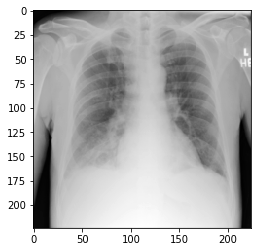

In [15]:
def join_str_array_to_labels(str_array,labels):
    return ','.join(['\n{}: {}'.format(
                                          labels[index_element], 
                                          str_array_element
                                        ) 
                for index_element, str_array_element in enumerate(str_array)])

#show how unbalanced dataset is
frequencies = np.sum(train_dataset_ex1.targets, axis = 0)/len(train_dataset_ex1)
text_frequencies = ['{:.2f}%'.format(frequency*100) for frequency in frequencies]                    
print('Percentage of positive examples for each class in the training set: ')
print(join_str_array_to_labels(text_frequencies, train_dataset_ex1.get_labels_name()))

#plot a few images
print('\n\nShowing one example from the dataset:')
plt.imshow(train_dataset_ex1[1][0].cpu().numpy()[0,:,:], cmap = 'gray')
print(join_str_array_to_labels(train_dataset_ex1[1][1],train_dataset_ex1.get_labels_name()))


#### Defining a scoring function for this exercise

In [16]:
#defining the function that calculates auc from a pair of arrays
def auroc(logits_predicted, target):
    series0, series1, _ = roc_curve(target, logits_predicted)
    return auc(series0, series1)

#defining the function that calculates the AUC score for exercise 1
# one of the inputs should be a model with which inference is made
# the model should have one array with 14 elements as output, and each output should be a score
# the highest this score is, the highest the probability of this class being present in the image
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_chestxray_binary_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        
        logits_predicted = np.zeros([0, 14])
        targets = np.zeros([0, 14])
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy()), axis = 0)
            targets = np.concatenate((targets, target.cpu().detach().numpy()), axis = 0)
            
    #returns a list of scores, one for each of the labels
    return [auroc(logits_predicted[:,i], targets[:,i]) for i in range(14)]

**Q 1.1 (22 points)**: Modify the resnet18 model provided in the torchvision package from PyTorch (https://pytorch.org/docs/stable/torchvision/models.html#id3) to output 14 binary classifiers, and train it on the ChestXray14 dataset. Justify your choice of loss function. Get an AUC of at least 0.725 on the validation set. You should average the AUC of the 14 classes to get a single AUC score. After getting the desired accuracy, test your best model on the test set, and specify for which anomaly/label your model got its best score and for which anomaly/label your model got its worst score. 

#### defining loss function

Instead of adding a sigmoid function to the neural network, we can use BCEWithLogits loss function and it would be numerically more stable. Using this loss function, the output of the models would be logits instead of probablity. This loss function would be used for all parts of this assignment.

In [17]:
criterion = torch.nn.BCEWithLogitsLoss()

#### loading datasets

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset_ex1, shuffle = True, batch_size = 20, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex1, batch_size = 20, num_workers = 8)
test_loader = torch.utils.data.DataLoader(test_dataset_ex1, batch_size = 20, num_workers = 8)

#### training CNN with different learning rates and saving the best one (highest AUC for validation set)

In [19]:
train_AUC={}
val_AUC={}
train_loss={}
learning_rates=[0.00001,0.00005,0.0001,0.0005]
best_auc=0;

for lr in learning_rates:
    model11 = models.resnet18(pretrained = True)
    #print(model11)
    model11.fc = torch.nn.Linear(in_features = 512, out_features = 14)
    model11 = model11.cuda()

    train_AUC[lr]=[]
    val_AUC[lr]=[]
    train_loss[lr]=[]
    optimizer11 = torch.optim.Adam(model11.parameters(), lr = lr)

    print('learning rate:', lr)

    for epoch in range(10): # 1)

        model11.train() # 2)

        losses11 = []

        for images, targets in train_loader: # 1)

            optimizer11.zero_grad() # 3)
            #images= data[0][0,:,:]
            #targets= data[1]

            #putting variables on GPU since model is on GPU
            images = images.cuda()
            targets = targets.cuda()

            #running each model by adapting the imagees tensor to the expected input size of each model
            out11 = model11(images.expand(-1, 3, -1, -1))
            #calculating the losses with the defined criterion
            loss11 = criterion(out11, targets)

            loss11.backward() # 4)

            optimizer11.step() # 5)

            losses11.append(loss11.item()) # 6) 7)

        print('Epoch ' + str(epoch)) # 6)
        print('loss11: ' + str(np.mean(losses11))) # 6)

        # Train and Validation AUC

        val_auc= np.mean(get_score_model_chestxray_binary_model(model11,val_loader))
        val_AUC[lr].append(val_auc)
        #train_auc= np.mean(get_score_model_chestxray_binary_model(model11,train_loader))
        #train_AUC[lr].append(train_auc)

        train_loss[lr].append(np.mean(losses11))  

        # Saving the best model
        if val_auc > best_auc:
            best_auc= val_auc
            best_model11= copy.deepcopy(model11)
            print('\033[91m' + 'Model Updated!' + '\033[0m', 'AUC:', best_auc)

learning rate: 1e-05
Epoch 0
loss11: 0.42177389258712666
Model Updated! AUC: 0.6035660869645266
Epoch 1
loss11: 0.20266990663643875
Model Updated! AUC: 0.652724739073878
Epoch 2
loss11: 0.16999035760153472
Model Updated! AUC: 0.6791054500733836
Epoch 3
loss11: 0.1561015331738405
Model Updated! AUC: 0.6998571093697014
Epoch 4
loss11: 0.14503978693444805
Model Updated! AUC: 0.705266275893127
Epoch 5
loss11: 0.133774912431499
Model Updated! AUC: 0.7062347001586992
Epoch 6
loss11: 0.1214957370831551
Epoch 7
loss11: 0.1080602957315035
Epoch 8
loss11: 0.09452299210685411
Epoch 9
loss11: 0.0811351002510047
learning rate: 5e-05
Epoch 0
loss11: 0.23524610002048954
Model Updated! AUC: 0.7121108933071353
Epoch 1
loss11: 0.14904785377070376
Model Updated! AUC: 0.7226094930021192
Epoch 2
loss11: 0.12751510015339063
Epoch 3
loss11: 0.09559135938830235
Epoch 4
loss11: 0.0580972175901899
Epoch 5
loss11: 0.030910208260817494
Epoch 6
loss11: 0.01722503877645232
Epoch 7
loss11: 0.010967061041571975
Epoch

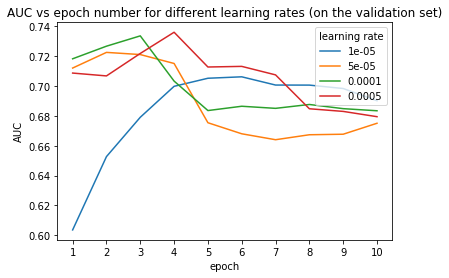

In [20]:
for key in val_AUC.keys():
    plt.plot(list(range(1,11)),val_AUC[key])
plt.legend(val_AUC.keys(),loc=1,title='learning rate')
plt.xticks(list(range(1,11)))
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch number for different learning rates (on the validation set)')
plt.show()

#### Analyzing the test set with the best model

In [21]:
test_AUC= get_score_model_chestxray_binary_model(best_model11,test_loader)
print('AUC for different labels')
print(join_str_array_to_labels(test_AUC, train_dataset_ex1.get_labels_name()))

AUC for different labels

Atelectasis: 0.7698837145521364,
Cardiomegaly: 0.8986540364880731,
Effusion: 0.8368765451034881,
Infiltration: 0.6579110810478416,
Mass: 0.6734042526265702,
Nodule: 0.6010078582047766,
Pneumonia: 0.646650442106548,
Pneumothorax: 0.7744390865218692,
Consolidation: 0.7698945349952061,
Edema: 0.8252084014383785,
Emphysema: 0.7222843450479234,
Fibrosis: 0.7168684488502478,
Pleural_Thickening: 0.7534996077813553,
Hernia: 0.7875253428741801


In [246]:
print('average AUC for the test set is:', np.mean(test_AUC))

average AUC for the test set is: 0.7452934069741852


In [22]:
max_index= test_AUC.index(max(test_AUC))
min_index= test_AUC.index(min(test_AUC))
labels= test_dataset_ex1.get_labels_name()

print('The maximum AUC is achived for {}: {}'.format(labels[max_index],test_AUC[max_index]))
print('The minimum AUC is achived for {}: {}'.format(labels[min_index],test_AUC[min_index]))

The maximum AUC is achived for Cardiomegaly: 0.8986540364880731
The minimum AUC is achived for Nodule: 0.6010078582047766


In [23]:
#saving the best model as it may be needed later
torch.save(best_model11, 'best_model11')

**Q 1.2 (34 points)**: Build a model of your own design with a maximum of 500,000 parameters that reaches at least 0.67  AUC on the validation set when trained from scratch. You should average the AUC of the 14 classes to get a single AUC score. Besides getting a good score, you should also test several different architectures, methods and hyperparameters, and describe/analyze what worked well and what didn't.

#### loading the dataset

In [247]:
train_loader = torch.utils.data.DataLoader(train_dataset_ex1, shuffle = True, batch_size = 20, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex1, batch_size = 20, num_workers = 8)
test_loader = torch.utils.data.DataLoader(test_dataset_ex1, batch_size = 20, num_workers = 8)

#### defining the model

In [248]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.convolution_layer_1 = torch.nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5)
        self.relu = torch.nn.ReLU()
        self.maxpooling_layer = torch.nn.MaxPool2d(kernel_size = 2)
        self.convolution_layer_2 = torch.nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5)
        self.convolution_layer_3 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5)
        self.convolution_layer_4 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5)
        self.convolution_layer_5 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5)
        self.fully_connected_layer = torch.nn.Linear(in_features = 1152, out_features = 14)
        
    def forward(self, x):
        x = self.convolution_layer_1(x)
        x = self.relu(x)
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_2(x)
        x = self.relu(x)
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_3(x)
        x = self.relu(x)
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_4(x)
        x = self.relu(x)
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_5(x)
        x = self.relu(x)
        x = self.maxpooling_layer(x)
        
        #flattening the tensor so that it can serve as input to a linear layer
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layer(x)
        return x
      
model12 = ConvNet()
model12 = model12.cuda()

In [249]:
print('this network has {} number of trainable parameters'.format(count_number_parameters(model12)))

this network has 288990 number of trainable parameters


#### weight initialization

In [250]:
torch.nn.init.xavier_normal_(model12.convolution_layer_1.weight);

#### training the model

In [253]:
val_AUC={}
train_loss={}
learning_rates=[0.00001,0.00005,0.0001,0.0005]
best_auc=0;

for lr in learning_rates:
    model12 = ConvNet()
    model12 = model12.cuda()
    
    # wright initialization"
    torch.nn.init.xavier_normal_(model12.convolution_layer_1.weight);

    val_AUC[lr]=[]
    train_loss[lr]=[]
    optimizer12 = torch.optim.Adam(model12.parameters(), lr = lr)

    print('learning rate:', lr)

    for epoch in range(20): # 1)

        model12.train() # 2)

        losses12 = []

        for images, targets in train_loader: # 1)

            optimizer12.zero_grad() # 3)
            #images= data[0][0,:,:]
            #targets= data[1]

            #putting variables on GPU since model is on GPU
            images = images.cuda()
            targets = targets.cuda()

            #running each model by adapting the imagees tensor to the expected input size of each model
            out12 = model12(images)
            #calculating the losses with the defined criterion
            loss12 = criterion(out12, targets)

            loss12.backward() # 4)

            optimizer12.step() # 5)

            losses12.append(loss12.item()) # 6) 7)

        print('Epoch ' + str(epoch)) # 6)
        print('loss12: ' + str(np.mean(losses12))) # 6)

        # Train and Validation AUC

        val_auc= np.mean(get_score_model_chestxray_binary_model(model12,val_loader))
        val_AUC[lr].append(val_auc)
        #train_auc= np.mean(get_score_model_chestxray_binary_model(model12,train_loader))
        #train_AUC[lr].append(train_auc)

        train_loss[lr].append(np.mean(losses12))  

        # Saving the best model
        if val_auc > best_auc:
            best_auc= val_auc
            best_model12= copy.deepcopy(model12)
            print('\033[91m' + 'Model Updated!' + '\033[0m', 'AUC:', best_auc)

learning rate: 1e-05
Epoch 0
loss12: 0.3035212631307846
Model Updated! AUC: 0.4850965190227969
Epoch 1
loss12: 0.18066047710193767
Model Updated! AUC: 0.490905406533077
Epoch 2
loss12: 0.17958846976517012
Model Updated! AUC: 0.4956834259622322
Epoch 3
loss12: 0.1785796739632997
Model Updated! AUC: 0.5017842519462918
Epoch 4
loss12: 0.1776986995298938
Model Updated! AUC: 0.5090840278650381
Epoch 5
loss12: 0.17678345741527113
Model Updated! AUC: 0.5173464008533363
Epoch 6
loss12: 0.1760333735175532
Model Updated! AUC: 0.5245367192159922
Epoch 7
loss12: 0.17537259293627416
Model Updated! AUC: 0.5362345046912682
Epoch 8
loss12: 0.17463177752710576
Model Updated! AUC: 0.5461609438978743
Epoch 9
loss12: 0.17401175165540492
Model Updated! AUC: 0.552513913747202
Epoch 10
loss12: 0.1735243968901591
Model Updated! AUC: 0.5590340944684508
Epoch 11
loss12: 0.17300698301034276
Model Updated! AUC: 0.5660877146989419
Epoch 12
loss12: 0.172387017046704
Model Updated! AUC: 0.5742218943637665
Epoch 13
l

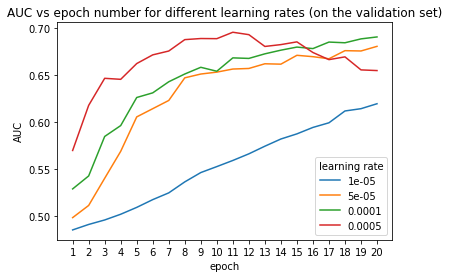

In [255]:
for key in val_AUC.keys():
    plt.plot(list(range(1,21)),val_AUC[key])
plt.legend(val_AUC.keys(),loc=4,title='learning rate')
plt.xticks(list(range(1,21)))
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch number for different learning rates (on the validation set)')
plt.show()

#### analyzing the test set with the best model

In [261]:
test_AUC= get_score_model_chestxray_binary_model(best_model12,test_loader)
print('AUC for different labels')
print(join_str_array_to_labels(test_AUC, train_dataset_ex1.get_labels_name()))

AUC for different labels

Atelectasis: 0.7120808748050808,
Cardiomegaly: 0.8272967330632591,
Effusion: 0.7844873865420359,
Infiltration: 0.6699391218792277,
Mass: 0.6343581449618702,
Nodule: 0.5770106213409362,
Pneumonia: 0.6634573571259641,
Pneumothorax: 0.6424225436975767,
Consolidation: 0.7336400233389335,
Edema: 0.8217690966546801,
Emphysema: 0.4882617441722873,
Fibrosis: 0.7559569757048834,
Pleural_Thickening: 0.5873925501432664,
Hernia: 0.7249850924269529


In [262]:
print('average AUC for the test set is', np.mean(test_AUC))

average AUC for the test set is 0.6873613047040683


In [263]:
max_index= test_AUC.index(max(test_AUC))
min_index= test_AUC.index(min(test_AUC))
labels= test_dataset_ex1.get_labels_name()

print('The maximum AUC is achived for {}: {}'.format(labels[max_index],test_AUC[max_index]))
print('The minimum AUC is achived for {}: {}'.format(labels[min_index],test_AUC[min_index]))

The maximum AUC is achived for Cardiomegaly: 0.8272967330632591
The minimum AUC is achived for Emphysema: 0.4882617441722873


In [257]:
#saving the best model as it may be needed later
torch.save(best_model12, 'best_model12_1')

As it can be seen, a 5 layer network reached the required auc. It also showed a pretty good performance of the test set.
I tried 2-layer and 3-layer networks but could not reach the required auc. Also, the output of the 5th layer of this network is a 3$\times$3 matrix, I tried adding another conv layer with kernel size of 3, so the output of that layer would be a 1$\times$1 matrix. The performance decreased by doing so.

# Exercise 2: RSNA Pneumonia Detection Challenge
**(44 points total)**

In this exercise we will be using a dataset from Kaggle. Kaggle is a website that hosts machine learning competitions and datasets, and is a great resource for finding interesting projects for practicing deep learning concepts. You will have to create a Kaggle account to access the dataset for this exercise. You will need to register for this Kaggle competition (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge), accept the terms, and get an API key for your account on Kaggle. To get this key, you should do:

- click on your image on the upper right corner of a Kaggle webpage
- click on "My Account"
- click on the button "Create New API Token"
- Save the key inside the json file somewhere.

Below you will be asked for this key, so that a script can connect to the Kaggle databases and download the files to your system. 

The dataset for this exercise is a dataset which has images labeled as having pneumonia or not and, for each image with pneumonia, bounding boxes are provided to know where the evidence for pneumonia is in the image. The original dataset is evaluated as an object detection task, by mean average precision of bounding boxes (more details here, if you are curious: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge#evaluation ). Some famous models predict bounding boxes directly (https://pjreddie.com/darknet/yolo/, for example). However, we are going to simplify the task and convert the ground truth bounding boxes to a grid of binary labels, train a model using these modified labels, and use the AUC metric to evaluate them. 

**Important:** Please download the file **image_names_kaggle_pneumonia.csv** provided with the assignment and put it in the same directory as this notebook. If you are using Google Colaboratory, use the python command ```files.upload()``` below to upload the file.

#### Getting the dataset and defining loading and processing  steps

In [24]:
# If you are using Google Colaboratory, use the next line to upload the image_names_kaggle_pneumonia.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [31]:
#getting Kaggle username for the API connection
print("Write your kaggle username:")
kaggle_username = getpass.getpass()

Write your kaggle username:
········


In [26]:
#getting Kaggle API key for the API connection
#check Exercise 2 for how to get this key
print("Write your kaggle key:")
kaggle_key = getpass.getpass()

Write your kaggle key:
········


In [32]:
if pneumonia_dataset_folder!='/scratch/tmp/deep_learning_datasets_ECE_6960_013/kaggle_pneumonia':
    #downloading the dataset
    os.environ['KAGGLE_USERNAME']=kaggle_username
    os.environ['KAGGLE_KEY']=kaggle_key
    os.makedirs(pneumonia_dataset_folder, exist_ok=True)
    !kaggle competitions download -c rsna-pneumonia-detection-challenge -p $pneumonia_dataset_folder

In [33]:
if pneumonia_dataset_folder!='/scratch/tmp/deep_learning_datasets_ECE_6960_013/kaggle_pneumonia':
    #extracting the dataset
    c1 = pneumonia_dataset_folder+'/stage_2_train_images.zip'
    d1 = pneumonia_dataset_folder+'/stage_2_train_images'
    e1 = pneumonia_dataset_folder+'/stage_2_train_labels.csv.zip'

    !unzip -n $c1 -d $d1
    !unzip -n $e1 -d $pneumonia_dataset_folder

In [34]:
# creating a pytorch dataset class
# it contains the data reading, indexing and preprocessing for the RSNA pneumonia localization dataset
class RSNAPneumoniaDetectionDataset(Dataset):
    
    # defining a function that receives a list of bounding boxes and transform it 
    # into a spatial grid of positive and negative labels, positive labels corresponding to
    # the bounding boxes locations
    def get_grid(self, bounding_boxes):
        #images of this dataset are 1024x1024 pixels
        image_original_size = 1024
        
        
        grid_size = self.grid_size
        
        # start by creating a grid with the same size as the original image
        # since it is easy to know how each bounding box should be translated to 0/1 
        # grid cells
        # set as 1 cells inside bounding boxes, and 0 cells outside bounding boxes
        this_grid = torch.zeros([1,1,image_original_size,image_original_size], dtype = torch.float)
        for bounding_box in bounding_boxes:
            if bounding_box[0]!=bounding_box[0]:
                continue
            y1 = int(bounding_box[1])
            y2 = y1 + int(bounding_box[3])
            x1 = int(bounding_box[0])
            x2 = x1 + int(bounding_box[2])
            this_grid[:,:,y1:y2, x1:x2] = 1.0
        
        #reduce the image to a size that is a multiple of the grid size, to be able to 
        # use average pooling with well defined kernel cells
        first_resize_size = (image_original_size//self.grid_size)*self.grid_size
        this_grid = torch.nn.functional.interpolate(this_grid, size = (first_resize_size, first_resize_size), mode = 'bilinear', align_corners = False)
        this_grid = torch.nn.AvgPool2d(kernel_size = image_original_size//grid_size)(this_grid)
        
        #this_grid now should contain a number from 0 to 1 specifying how much of that particular cell
        #is being occupied by a bounding box
        
        # only set as positive labeled the cells that had more than 50% of its area 
        # occupied by bounding boxes
        this_grid = ((this_grid[0,:,:,:][:]>0.5)*1.0).float()
        return this_grid
    
    #split can be 'train', 'val', and 'test'
    def __init__(self, path_dataset_folder, grid_size, split = 'train'):
        self.path_image_folder = path_dataset_folder + '/stage_2_train_images'
        self.grid_size = grid_size
        
        #get the filenames of all images inside the dataset
        all_images_list = !find $self.path_image_folder -type f -name "*.dcm" |sed 's#.*/##' | sed 's/\.[^.]*$//'

        #read the labels file
        label_filename = path_dataset_folder + '/stage_2_train_labels.csv'
        label_file = pd.read_csv(label_filename)
        
        # getting the list of all patient ids present in the dataset, to split into
        # training, validation and testing by patient id
        all_images_list =  pd.read_csv('image_names_kaggle_pneumonia.csv')['patientId'].values

        all_images_list = pd.DataFrame(get_split(all_images_list, split), columns = ['patientId'])
        
        examples_to_use = pd.merge(all_images_list, label_file)
        
        # put all bounding boxes coordinates as a list of coordinates in a single column    
        dataframe_with_listed_bounding_boxes = examples_to_use
        dataframe_with_listed_bounding_boxes['x'] = dataframe_with_listed_bounding_boxes['x'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['y'] = dataframe_with_listed_bounding_boxes['y'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['width'] = dataframe_with_listed_bounding_boxes['width'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['height'] = dataframe_with_listed_bounding_boxes['height'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['bounding_boxes'] = dataframe_with_listed_bounding_boxes['x'] + \
                                                                dataframe_with_listed_bounding_boxes['y'] + \
                                                                dataframe_with_listed_bounding_boxes['width'] + \
                                                                dataframe_with_listed_bounding_boxes['height']
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes[['patientId', 'bounding_boxes']]
        
        # Since bounding boxes for the same patient id are stored in more than one label line, 
        # group them by patient id and create a list of bounding boxes for each patient id
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes.groupby('patientId')
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes.aggregate(lambda x: tuple(x)).reset_index()
        
        # transform all lists of bounding boxes to grids
        dataframe_with_listed_bounding_boxes['bounding_boxes'] = dataframe_with_listed_bounding_boxes['bounding_boxes'].apply(lambda x: self.get_grid(x))
        
        #join the tables with targets and grids
        examples_to_use = examples_to_use[['patientId', 'Target']].drop_duplicates()
        examples_to_use = pd.merge(examples_to_use, dataframe_with_listed_bounding_boxes)
        assert(len(examples_to_use) == len(all_images_list))
        
        self.image_list = examples_to_use['patientId'].values
        self.targets = examples_to_use['Target'].values
        self.grids = examples_to_use['bounding_boxes'].values
        
    def __getitem__(self, index):
        #defining the transformations to do to the images before feeding it to the deep learning model
        #these include cropping it to a square, resizing it to the usual ImageNet used size, transform it into a pytorch
        # tensor, and normalizing it using the ImageNet dataset average and standard deviation per channel
        set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
         transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        image_to_return = set_of_transforms(Image.fromarray(pydicom.dcmread(self.path_image_folder + '/' + self.image_list[index] + '.dcm').pixel_array))
        
        #the first element of the returned elements is a 3-channel image stored in a pytorch tensor
        # the second element is a single binary label specifying the target label for that image, 
        # the third element is a 1-channel spatial grid specifying coarsely where in the image positive labels are present
        return image_to_return, torch.FloatTensor(self.targets[index:index + 1]), torch.FloatTensor(self.grids[index])
    
    def __len__(self):
        return len(self.image_list)

#### Setting the variables that you should use as datasets for Exercise 1

In [35]:
#creating the datasets to be used in exercise 2
# this may take a few minutes
train_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, grid_size  = 14)
val_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, split = 'val', grid_size  = 14)
test_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, split = 'test', grid_size  = 14)

# if any of the following asserts fail, please contact the TA
assert(len(train_dataset_ex2) == 16010)
assert(len(val_dataset_ex2) == 5337)
assert(len(test_dataset_ex2) == 5337)
assert(sum(train_dataset_ex2.targets) == 3603)
assert(sum(val_dataset_ex2.targets) == 1195)
assert(np.sum([grid.numpy() for grid in train_dataset_ex2.grids]) == 81251)

#### Short visualization of the resulting dataset

Percentage of positive examples for whole images: 22.50%
Percentage of positive examples for grid cells: 2.59%

Visualizing a few examples: 
Label pneumonia: 1.0


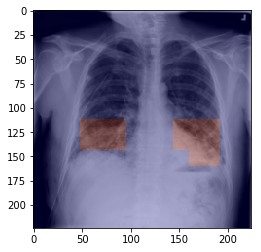

Label pneumonia: 1.0


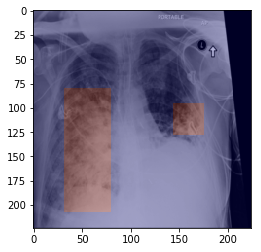

Label pneumonia: 0.0


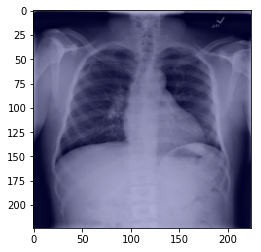

In [36]:
#show how unbalanced dataset is
frequency = np.sum(train_dataset_ex2.targets, axis = 0)/len(train_dataset_ex2)
                
print('Percentage of positive examples for whole images: ' + '{:.2f}'.format(frequency*100) + '%')


frequency = np.sum([grid.numpy() for grid in train_dataset_ex2.grids])/len(train_dataset_ex2)/14/14
print('Percentage of positive examples for grid cells: ' + '{:.2f}'.format(frequency*100) + '%')

def imresize(arr, size, resample):
    return np.array(Image.fromarray(arr).resize(size, resample))

def plot_grid_over_xray(example):
    image = example[0].numpy()[0,:,:]
    print('Label pneumonia: ' + str(example[1][0].cpu().numpy()))
    max1 = np.max(image)
    min1 = np.min(image)
    fig, ax = plt.subplots()
    ax.imshow((image-min1)/(max1 - min1), cmap = 'gray')
    ax.imshow(imresize(example[2].numpy()[0,:,:], (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
    plt.show()

print('\nVisualizing a few examples: ')
#plot a few images from the dataset
# reddish areas mean ones in the grid (pneumonia presence)
#blueish areas mean zeros in the grid (pneumonia absence)
example =  train_dataset_ex2[1]
plot_grid_over_xray(train_dataset_ex2[1])
plot_grid_over_xray(train_dataset_ex2[10])
plot_grid_over_xray(train_dataset_ex2[0])

#### Defining scoring functions for this exercise

In [37]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a spatial grid of scores, for the task
# of localizing where in an image there is evidence for pneumonia
# one of the inputs of this function should be a model with which inference is made
# the model should have one single score as output
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_location_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            # each grid cell target is considered a different example for calculating the score
            # for that, all outputs and target are reshaped to have only one value in the second dimension
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.view([-1,1]).cpu().numpy()), axis = 0)
            targets = np.concatenate((targets, grid.view([-1,1]).cpu().numpy()), axis = 0)
    return auroc(logits_predicted[:,0], targets[:,0])

In [38]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a single score for the task of classifying
# if an image contains evidence for pneumonia or not.
# one of the inputs should be a model with which inference is made
# the model should have one single score as output
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_binary_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0,1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().numpy()), axis = 0)
            
            targets = np.concatenate((targets, target.cpu().numpy()), axis = 0)
    return auroc(logits_predicted, targets)

In [39]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a grid of scores, but this grid is converted
# to a single number to adapt this score to the binary task of saying if the whole image
# has evidence for pneumonia or not
# one of the inputs should be a model with which inference is made
# the model should have one array with 196 (14x14) elements as output, and each output should be a score
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_binary_with_location_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0,1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            
            #to convert a grid of labels to a single binary logit, we take the maximum logit 
            # in the grid. We do this since having only one grid cell labeled as positive means the whole
            # image should be labeled as having pneumonia.
            logits_predicted = np.concatenate((logits_predicted, torch.max(logit_predicted.view(logit_predicted.shape[0], -1),dim = 1)[0].view(-1,1).cpu().numpy()), axis = 0)
            targets = np.concatenate((targets, target.cpu().numpy()), axis = 0)
    return auroc(logits_predicted[:,0], targets[:,0])

**Q 2.1 (22 points)**: Modify the resnet18 model from PyTorch to output a flattened 14x14 grid, and train it on the pneumonia dataset to get an AUC of at least 0.97 in the validation set. The output of layer3 in the resnet18 model is already 14x14, so you should remove layer4 from the model and use the output of layer3. After getting the desired accuracy, test your best model on the test set. Select a few test examples for which your model got the locations correctly and a few examples with mistakes. Comment and show a visualization for them.

#### loading the dataset

In [40]:
train_loader = torch.utils.data.DataLoader(train_dataset_ex2, shuffle = True, batch_size = 20, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex2, batch_size = 20, num_workers = 8)
test_loader = torch.utils.data.DataLoader(test_dataset_ex2, batch_size = 20, num_workers = 8)

#### defining the loss function

In [41]:
criterion = torch.nn.BCEWithLogitsLoss()

#### defining the model

In [42]:
val_AUC21={}
train_loss={}
learning_rates=[0.00001,0.00005,0.0001,0.0005]
best_auc21=0;

for lr in learning_rates:
    model21 = models.resnet18(pretrained = True)
    modules=list(model21.children())[:-3]
    model21=torch.nn.Sequential(*modules)
    model21.add_module('convout', torch.nn.Conv2d(256,1,kernel_size=(1, 1)))
    model21=model21.cuda()
    
    
    train_AUC[lr]=[]
    val_AUC21[lr]=[]
    train_loss[lr]=[]
    optimizer21 = torch.optim.Adam(model21.parameters(), lr = lr)

    print('learning rate:', lr)

    for epoch in range(10): # 1)

        model21.train() # 2)

        losses21 = []

        for images,check,targets in train_loader: # 1)

            optimizer21.zero_grad() # 3)
            #images= data[0][0,:,:]
            #targets= data[2]

            #putting variables on GPU since model is on GPU
            images = images.cuda()
            targets = targets.cuda()

            #running each model by adapting the imagees tensor to the expected input size of each model
            out21 = model21(images.expand(-1,3,-1,-1))
            #calculating the losses with the defined criterion
            loss21 = criterion(out21, targets)

            loss21.backward() # 4)

            optimizer21.step() # 5)

            losses21.append(loss21.item()) # 6) 7)

        print('Epoch ' + str(epoch)) # 6)
        print('loss21: ' + str(np.mean(losses21))) # 6)

        # Train and Validation AUC
        val_auc= get_score_model_pneumonia_location_model(model21, val_loader)
        val_AUC21[lr].append(val_auc)
        #train_auc= np.mean(get_score_model_chestxray_binary_model(model11,train_loader))
        #train_AUC[lr].append(train_auc)

        train_loss[lr].append(np.mean(losses21))  

        # Saving the best model
        if val_auc > best_auc21:
            best_auc21= val_auc
            best_model21= copy.deepcopy(model21)
            print('\033[91m' + 'Model Updated!' + '\033[0m', 'AUC:', best_auc21)


      

learning rate: 1e-05
Epoch 0
loss21: 0.49782583195618474
Model Updated! AUC: 0.8945039557564678
Epoch 1
loss21: 0.3083498703778609
Model Updated! AUC: 0.9392496572720114
Epoch 2
loss21: 0.22654500735758545
Model Updated! AUC: 0.9474425661506335
Epoch 3
loss21: 0.17219605524739373
Model Updated! AUC: 0.9567672667340278
Epoch 4
loss21: 0.13549358085188526
Model Updated! AUC: 0.9591020967616583
Epoch 5
loss21: 0.11100145125210509
Model Updated! AUC: 0.9629719411212594
Epoch 6
loss21: 0.09406643048319477
Model Updated! AUC: 0.965939366142829
Epoch 7
loss21: 0.08237233730533002
Model Updated! AUC: 0.9669510289225016
Epoch 8
loss21: 0.07467502588115531
Model Updated! AUC: 0.9687358423574127
Epoch 9
loss21: 0.06926773049021034
Model Updated! AUC: 0.9697820334170151
learning rate: 5e-05
Epoch 0
loss21: 0.25345433074585655
Epoch 1
loss21: 0.0923228771489732
Epoch 2
loss21: 0.06873773596250683
Model Updated! AUC: 0.9708094593173207
Epoch 3
loss21: 0.06129060605175784
Model Updated! AUC: 0.972467

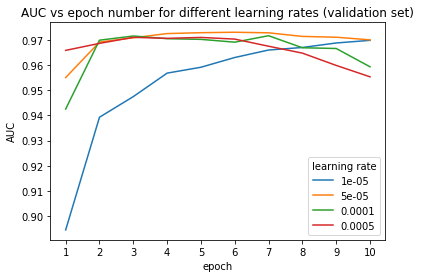

In [161]:
for key in val_AUC21.keys():
    plt.plot(list(range(1,11)),val_AUC21[key])
plt.legend(val_AUC21.keys(),loc=4,title='learning rate')
plt.xticks(list(range(1,11)))
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch number for different learning rates (validation set)')
plt.show()

In [44]:
print('The AUC of the best model on the validation set is:',get_score_model_pneumonia_location_model(best_model21, val_loader))

The AUC of the best model on the validation set is: 0.9730000836969175


#### testing the best model on the test set

In [45]:
print('The AUC of the best model on the test set is:',get_score_model_pneumonia_location_model(best_model21, test_loader))

The AUC of the best model on the test set is: 0.9734574177061213


In [48]:
#saving the best model as it may be needed later
torch.save(best_model21, 'best_model21')

#### visualizing exmaples form the test set where the model got it right and wrong

In [49]:
test_loader = torch.utils.data.DataLoader(test_dataset_ex2, batch_size = 1, num_workers = 8)

Actual Label pneumonia: 1.0
Correct locating by the model


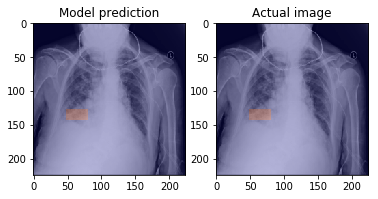

Actual Label pneumonia: 1.0
Incorrect locating by the model


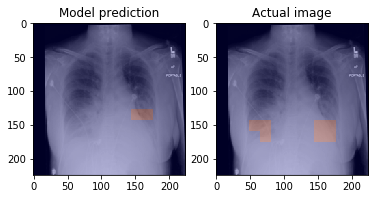

Actual Label pneumonia: 1.0
Correct locating by the model


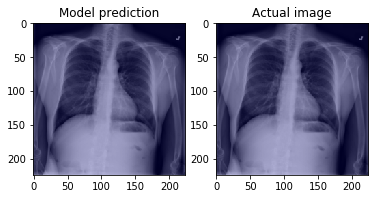

Actual Label pneumonia: 1.0
Incorrect locating by the model


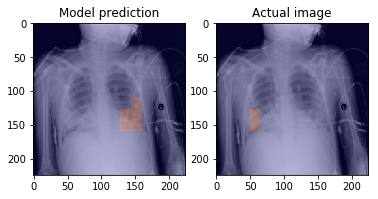

Actual Label pneumonia: 1.0
Incorrect locating by the model


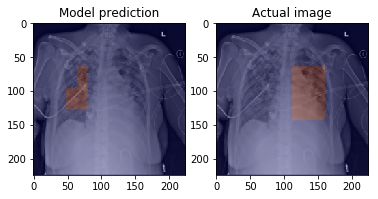

Actual Label pneumonia: 1.0
Correct locating by the model


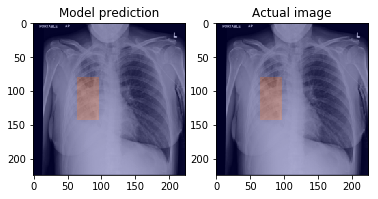

In [143]:
true_examples_number=0
false_examples_number=0
with torch.no_grad():
    while false_examples_number<3 or true_examples_number<3:
        best_model21.eval()
        for images, targets, grids in test_loader:

            images = images.cuda()
            grids = grids.cuda()

            out21 = (torch.sigmoid(best_model21(images.expand(-1, 3, -1, -1)))>0.5).float()
            if (out21==grids).cpu().numpy().all() and true_examples_number<3 and targets==1:
                true_examples_number+=1
                image=images.view(3,224,224).cpu().numpy()[0,:,:]
                print('Actual Label pneumonia: ' + str(targets.item()))
                print('Correct locating by the model')
                image=images.view(3,224,224).cpu().numpy()[0,:,:]
                max1 = np.max(image)
                min1 = np.min(image)
                fig, ax = plt.subplots(1,2)
                ax[0].imshow((image-min1)/(max1 - min1), cmap = 'gray')
                ax[0].imshow(imresize(out21.view(14,14).cpu().numpy(), (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
                ax[0].set_title('Model prediction')
                ax[1].imshow((image-min1)/(max1 - min1), cmap = 'gray')
                ax[1].imshow(imresize(grids.view(14,14).cpu().numpy(), (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
                ax[1].set_title('Actual image')
                plt.show()
            if (out21*grids==0).all() and false_examples_number<3 and targets==1 and (out21==1).any():
                false_examples_number+=1
                image=images.view(3,224,224).cpu().numpy()[0,:,:]
                print('Actual Label pneumonia: ' + str(targets.item()))
                print('Incorrect locating by the model')
                image=images.view(3,224,224).cpu().numpy()[0,:,:]
                max1 = np.max(image)
                min1 = np.min(image)
                fig, ax = plt.subplots(1,2)
                ax[0].imshow((image-min1)/(max1 - min1), cmap = 'gray')
                ax[0].imshow(imresize(out21.view(14,14).cpu().numpy(), (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
                ax[0].set_title('Model prediction')
                ax[1].imshow((image-min1)/(max1 - min1), cmap = 'gray')
                ax[1].imshow(imresize(grids.view(14,14).cpu().numpy(), (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
                ax[1].set_title('Actual image')
                plt.show()

**Q 2.2 (22 points)**: Modify the resnet18 model from PyTorch to have a single output and the same number of parameters of your model in question 2.1. For training this model, you are only allowed to use the pneumonia binary target for the whole image as ground truth, and you are not allowed to use the grid target. You should be able to achieve an AUC of at least 0.865.

Also train a model just like the one from question 2.1, this time validating with a score for the binary task of presence or absence of pneumonia on an image. This score is calculated by the function ```get_score_model_pneumonia_binary_with_location_model```. When converting from a grid to a single output, this function considers that the probability of an image having pneumonia is the maximum probability over the grid.

Compare both models on their scores for the binary task. Analyze why you got these results. Test your best model for the binary task on the test set.

#### loading the dataset

In [144]:
train_loader = torch.utils.data.DataLoader(train_dataset_ex2, shuffle = True, batch_size = 20, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex2, batch_size = 20, num_workers = 8)
test_loader = torch.utils.data.DataLoader(test_dataset_ex2, batch_size = 20, num_workers = 8)

In [145]:
val_AUC22={}
train_loss={}
learning_rates=[0.00001,0.00005,0.0001,0.0005,0.001]
best_auc22=0;

# defining a class to reshape the output to match the targets
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0],1)

for lr in learning_rates:
    model22 = models.resnet18(pretrained = True)
    modules=list(model22.children())[:-3]
    model22=torch.nn.Sequential(*modules)
    model22.add_module('convout', torch.nn.Conv2d(256,1,kernel_size=(1, 1)))
    model22.add_module('maxpoolout', torch.nn.MaxPool2d(kernel_size=14))
    model22.add_module('reshape',Reshape())
    model22=model22.cuda()
    
    
    val_AUC22[lr]=[]
    train_loss[lr]=[]
    optimizer22 = torch.optim.Adam(model22.parameters(), lr = lr)

    print('learning rate:', lr)

    for epoch in range(10): # 1)

        model22.train() # 2)

        losses22 = []

        for images,targets,grids in train_loader: # 1)

            optimizer22.zero_grad() # 3)
            #images= data[0][0,:,:]
            #targets= data[2]

            #putting variables on GPU since model is on GPU
            images = images.cuda()
            targets = targets.cuda()
            #targets.unsqueeze_(-1)
            #targets.unsqueeze_(-1)
            #running each model by adapting the imagees tensor to the expected input size of each model
            out22 = model22(images.expand(-1,3,-1,-1))
            #calculating the losses with the defined criterion
            loss22 = criterion(out22, targets)

            loss22.backward() # 4)

            optimizer22.step() # 5)

            losses22.append(loss22.item()) # 6) 7)

        print('Epoch ' + str(epoch)) # 6)
        print('loss22: ' + str(np.mean(losses22))) # 6)

        # Train and Validation AUC
        val_auc= get_score_model_pneumonia_binary_model(model22, val_loader)
        val_AUC22[lr].append(val_auc)
        #train_auc= np.mean(get_score_model_chestxray_binary_model(model11,train_loader))
        #train_AUC[lr].append(train_auc)

        train_loss[lr].append(np.mean(losses22))  

        # Saving the best model
        if val_auc > best_auc22:
            best_auc22= val_auc
            best_model22= copy.deepcopy(model22)
            print('\033[91m' + 'Model Updated!' + '\033[0m', 'AUC:', best_auc22)

learning rate: 1e-05
Epoch 0
loss22: 0.6765592779113112
Model Updated! AUC: 0.8084174968533383
Epoch 1
loss22: 0.5728559973608986
Model Updated! AUC: 0.8445892571049904
Epoch 2
loss22: 0.4877821892016241
Model Updated! AUC: 0.8574747105374276
Epoch 3
loss22: 0.4356447425525584
Model Updated! AUC: 0.8635575157232069
Epoch 4
loss22: 0.40129531125599677
Model Updated! AUC: 0.8667954962836055
Epoch 5
loss22: 0.37679602486661606
Model Updated! AUC: 0.8703004632613356
Epoch 6
loss22: 0.3581122472677636
Model Updated! AUC: 0.872562524117672
Epoch 7
loss22: 0.34125783743706534
Model Updated! AUC: 0.8744596126222045
Epoch 8
loss22: 0.322120935971222
Epoch 9
loss22: 0.30619106503126775
learning rate: 5e-05
Epoch 0
loss22: 0.5256990732139118
Epoch 1
loss22: 0.3818394447980302
Epoch 2
loss22: 0.3508760246649366
Epoch 3
loss22: 0.3247241062506308
Model Updated! AUC: 0.8785606775373811
Epoch 4
loss22: 0.29570413068327567
Epoch 5
loss22: 0.2515349858597423
Epoch 6
loss22: 0.19908373575941304
Epoch 7


In [150]:
#saving the best model as it may be needed later
torch.save(best_model22, 'best_model21')

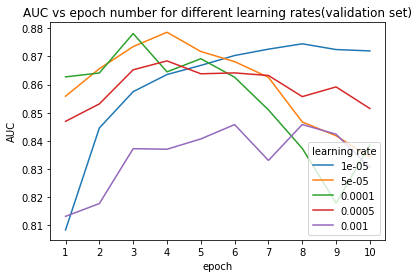

In [159]:
for key in val_AUC22.keys():
    plt.plot(list(range(1,11)),val_AUC22[key])
plt.legend(val_AUC22.keys(),loc=4,title='learning rate')
plt.xticks(list(range(1,11)))
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch number for different learning rates(validation set)')
plt.show()

In [148]:
print('The AUC of the best model on the validation set is:',get_score_model_pneumonia_binary_with_location_model(best_model22, val_loader))

The AUC of the best model on the validation set is: 0.8785606775373811


#### performance on the test set

In [149]:
print('The AUC of the best model on the test set is:',get_score_model_pneumonia_binary_with_location_model(best_model22, test_loader))

The AUC of the best model on the test set is: 0.8743465455369305


### second part (training on the grid)

In [152]:
val_AUC23={}
train_loss={}
learning_rates=[0.00001,0.00005,0.0001,0.0005]
best_auc23=0;

for lr in learning_rates:
    model23 = models.resnet18(pretrained = True)
    modules=list(model23.children())[:-3]
    model23=torch.nn.Sequential(*modules)
    model23.add_module('convout', torch.nn.Conv2d(256,1,kernel_size=(1, 1)))
    model23=model23.cuda()
    
    
    
    val_AUC23[lr]=[]
    train_loss[lr]=[]
    optimizer23 = torch.optim.Adam(model23.parameters(), lr = lr)

    print('learning rate:', lr)

    for epoch in range(10): # 1)

        model23.train() # 2)

        losses23 = []

        for images,check,targets in train_loader: # 1)

            optimizer23.zero_grad() # 3)
            #images= data[0][0,:,:]
            #targets= data[2]

            #putting variables on GPU since model is on GPU
            images = images.cuda()
            targets = targets.cuda()

            #running each model by adapting the imagees tensor to the expected input size of each model
            out23 = model23(images.expand(-1,3,-1,-1))
            #calculating the losses with the defined criterion
            loss23 = criterion(out23, targets)

            loss23.backward() # 4)

            optimizer23.step() # 5)

            losses23.append(loss23.item()) # 6) 7)

        print('Epoch ' + str(epoch)) # 6)
        print('loss23: ' + str(np.mean(losses23))) # 6)

        # Train and Validation AUC
        val_auc= get_score_model_pneumonia_binary_with_location_model(model23, val_loader)
        val_AUC23[lr].append(val_auc)
        #train_auc= np.mean(get_score_model_chestxray_binary_model(model11,train_loader))
        #train_AUC[lr].append(train_auc)

        train_loss[lr].append(np.mean(losses23))  

        # Saving the best model
        if val_auc > best_auc23:
            best_auc23= val_auc
            best_model23= copy.deepcopy(model23)
            print('\033[91m' + 'Model Updated!' + '\033[0m', 'AUC:', best_auc23)

learning rate: 1e-05
Epoch 0
loss23: 0.43377798040410254
Model Updated! AUC: 0.8150375073994534
Epoch 1
loss23: 0.253789841217197
Model Updated! AUC: 0.8465887762667965
Epoch 2
loss23: 0.1840510537450233
Model Updated! AUC: 0.8567449678666744
Epoch 3
loss23: 0.1410288398948204
Model Updated! AUC: 0.8609899811907413
Epoch 4
loss23: 0.11318958368380269
Model Updated! AUC: 0.8633520483100963
Epoch 5
loss23: 0.09492243867316347
Model Updated! AUC: 0.8673668451963659
Epoch 6
loss23: 0.08289630874786781
Model Updated! AUC: 0.8704193595962574
Epoch 7
loss23: 0.07468787025888166
Model Updated! AUC: 0.8720887570736753
Epoch 8
loss23: 0.06912950912813717
Epoch 9
loss23: 0.06549422909155693
Model Updated! AUC: 0.8749137824793067
learning rate: 5e-05
Epoch 0
loss23: 0.2511073372765129
Epoch 1
loss23: 0.09089854561006383
Epoch 2
loss23: 0.06821853384263953
Model Updated! AUC: 0.8760384993807693
Epoch 3
loss23: 0.061454458766792446
Model Updated! AUC: 0.8800215771088694
Epoch 4
loss23: 0.05801259418

In [153]:
#saving the best model as it may be needed later
torch.save(best_model23, 'best_model23')

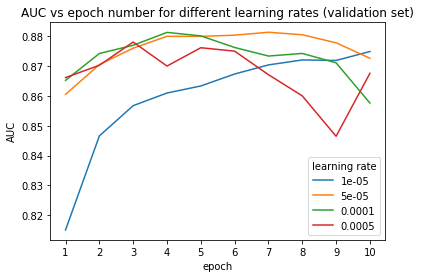

In [157]:
for key in val_AUC23.keys():
    plt.plot(list(range(1,11)),val_AUC23[key])
plt.legend(val_AUC23.keys(),loc=4,title='learning rate')
plt.xticks(list(range(1,11)))
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch number for different learning rates (validation set)')
plt.show()

In [155]:
print('The AUC of the best model on the validation set is:',get_score_model_pneumonia_binary_with_location_model(best_model23, val_loader))

The AUC of the best model on the validation set is: 0.8813861070087217


#### performance on the test set

In [156]:
print('The AUC of the best model on the test set is:',get_score_model_pneumonia_binary_with_location_model(best_model23, test_loader))

The AUC of the best model on the test set is: 0.8770710455790856


### Analysis

Two models show almost the same performance, although traing over the grid showed slightly better performance. This can be due to the fact that loss is calculated on a 14$\times$14 matrix rather than a single number. Also it can be seen that the AUC dropped more dramatically in the binary model since it overfittes more quickly on the training set.